# Shape Detector:


### Import Libraries

In [1]:
# import installed libraries
import tensorflow as tf
import numpy as np
import cv2 as cv2
import PIL as PIL
import scipy as sc
import sklearn as sk
import os

### Helper Functions

In [2]:
# https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


In [3]:
# https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py

def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [4]:
import cv2
import numpy as np
from PIL import Image


def disp_image(img):
    '''
    input: cv2 image 
    output: displays PIL image
    '''
    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    
    return im_pil

In [5]:
def read_shapes_text(text):
    with open(text, 'r') as fp:
        shape_count = fp.read().splitlines()
        assert(len(shape_count)==1)
        shape_count = shape_count[0].strip().split(', ')
        shape_count[0] = int(shape_count[0].strip().split(':')[1])
        shape_count[1] = int(shape_count[1].strip().split(':')[1])
        shape_count[2] = int(shape_count[2].strip().split(':')[1])
        shape_count = np.array(shape_count).reshape(1,-1)
    return shape_count

In [6]:
def accuracy(y, y_hat):
    num_images = y.shape[0]
    difference = y - y_hat
    
    num_squares = abs(difference[:,0:1]).sum()
    num_circles = abs(difference[:,1:2]).sum()
    num_triangles = abs(difference[:,2:3]).sum()
    num_shapes = difference.sum()
    
    acc_squares = (num_images - abs(num_squares)) / num_images
    acc_circles = (num_images - abs(num_circles)) / num_images
    acc_triangles = (num_images - abs(num_triangles)) / num_images
    acc_shapes = (num_images - abs(num_shapes)) / num_images
    
    print((acc_squares, acc_circles, acc_triangles), acc_shapes)
    
    return (acc_squares, acc_circles, acc_triangles), acc_shapes, difference

In [7]:
def ravel(image):
    '''
    input: image shape (500, 500, 3)
    output: image shape (1,750000)
    '''
    image = image.ravel().reshape(1,-1)
    return image

def unravel(image):
    '''
    input: image shape (1,750000)
    output: image shape (500, 500, 3)
    '''
    image = image.reshape(1,-1).reshape(500,500,3)
    return image


### Load DataSet

In [8]:
folder = 'training_data'

# create array with unique list of image names excluding '.jpg'
unique_contents = []
for path in os.listdir(folder):
    if path[-4:] == '.jpg':
        unique_contents.append(path[:-4])

assert(len(unique_contents) == 5000)

In [9]:
# init variables
X = []
y = []
img_paths = []

import timeit

timestart = timeit.default_timer()

# iterate over unique contents - process over batch-size for speed
for i, path in enumerate(unique_contents):
    image_path = folder + '/' + path +'.jpg'
    shapes_path = folder + '/' + path + '.txt'
    
    X_temp = ravel(cv2.imread(image_path))
    X.append(X_temp)
    
    y_temp = read_shapes_text(shapes_path)
    y.append(y_temp)
    
    img_paths.append(path)

    if i%500==0:
        timediff = timeit.default_timer() - timestart
        print('Read: ' + str(i) + ' images. Time: ' + str(timediff) + ' secs')
        
X = np.squeeze(X,1)
y = np.squeeze(y,1)
img_paths = np.array(img_paths).reshape(-1,1)

assert(X.shape == (5000, 750000))
assert(y.shape == (5000, 3))
assert(img_paths.shape == (5000, 1))

Read: 0 images. Time: 0.00782233699999324 secs
Read: 500 images. Time: 2.7009923130000004 secs
Read: 1000 images. Time: 5.228453032999994 secs
Read: 1500 images. Time: 7.752960091000006 secs
Read: 2000 images. Time: 10.221490356999993 secs
Read: 2500 images. Time: 12.738051819000006 secs
Read: 3000 images. Time: 15.220734610999997 secs
Read: 3500 images. Time: 17.788004110000003 secs
Read: 4000 images. Time: 20.357887923000007 secs
Read: 4500 images. Time: 22.952535186000006 secs


### Shape Detection

https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/

Implentation of shape detector - mostly borrowed from the link above.

In [10]:
# import the necessary packages
import cv2
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [11]:
def shape_detector(image, min_pixels=30, return_img=False):

    # load the image and resize it to a smaller factor so that
    # the shapes can be approximated better
    resized = resize(image, width=300)
    ratio = image.shape[0] / float(resized.shape[0])

    # convert the resized image to grayscale, blur it slightly,
    # and threshold it
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

    # find contours in the thresholded image and initialize the
    # shape detector
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = grab_contours(cnts)
    sd = ShapeDetector()
    
    # variables to count shapes
    num_cir = 0
    num_tri = 0
    num_sqr = 0
    unkn = 0    

    if return_img:
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape on the image
        for c in cnts:
            area = cv2.contourArea(c)
            if area > min_pixels:
                M = cv2.moments(c)
                cX = int((M["m10"] / (M["m00"] + 1e-7)) * ratio)
                cY = int((M["m01"] / (M["m00"] + 1e-7)) * ratio)
                shape = sd.detect(c)
                # multiply the contour (x, y)-coordinates by the resize ratio,
                # then draw the contours and the name of the shape on the image
                c = c.astype("float")
                c *= ratio
                c = c.astype("int")
                cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
                cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 255), 2)


                # count shapes
                if shape =='circle':
                    num_cir += 1
                elif shape =='triangle':
                    num_tri += 1
                elif shape=='square':
                    num_sqr += 1
                else:
                    unkn += 1

            num_shapes = np.array([num_sqr, num_cir, num_tri])

        return image, num_shapes
    else:
        for c in cnts:
            area = cv2.contourArea(c)
            if area > min_pixels:
                shape = sd.detect(c)
                area = cv2.contourArea(c)

                # count shapes
                if shape =='circle':
                    num_cir += 1
                elif shape =='triangle':
                    num_tri += 1
                elif shape=='square':
                    num_sqr += 1
                else:
                    unkn += 1

        num_shapes = np.array([num_sqr, num_cir, num_tri])

        return num_shapes

Example using black and white image from dataset. 

In [12]:
image_path = 'training_data/001A0B90010727-0016171-001C9A1-0012591-001DB8300110CE001C943.jpg'
image = cv2.imread(image_path)

overlay, num_shapes = shape_detector(image, return_img=True)

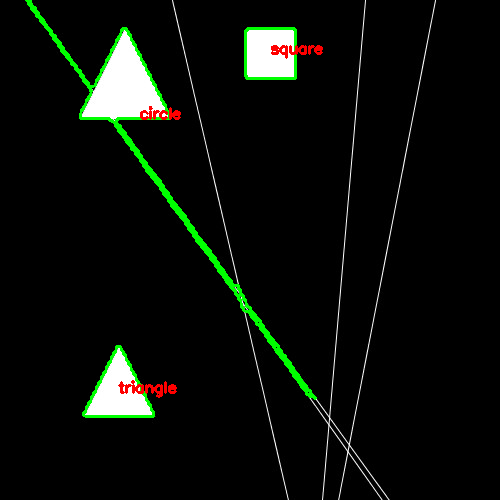

In [13]:
disp_image(overlay)

Clearly we have an error here, but we won't pay too much attention to this at this stage, only be concerned if there are similar errors after our preprocessing steps. 

### Reduce Color Space with K-Means Clustering

*After initial inspection it looks like there are more than two pixels in each image, which was the initial assumption - first reduce color space - then look at percentage of pixels to find the two dominant colours.

https://www.pyimagesearch.com/2014/07/07/color-quantization-opencv-using-k-means-clustering/

In [14]:
# import the necessary packages
from sklearn.cluster import MiniBatchKMeans

In [15]:
def reduce_C_space(image):
    '''
    input: image shape (500, 500, 3)
    output: image shape (500,500,3) with exactly two unique RGB pixels
    '''
    assert(image.shape == (500, 500, 3))
    
    # load the image and grab its width and height
    (h, w) = image.shape[:2]

    # convert the image from the RGB color space to the L*a*b*
    # color space -- since we will be clustering using k-means
    # which is based on the euclidean distance, we'll use the
    # L*a*b* color space where the euclidean distance implies
    # perceptual meaning
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # reshape the image into a feature vector so that k-means
    # can be applied
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    clt = MiniBatchKMeans(n_clusters = 2)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]

    # reshape the feature vectors to images
    quant = quant.reshape((h, w, 3))
    #image = image.reshape((h, w, 3))

    # convert from L*a*b* to RGB
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
    #image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    
    # number of unique pixels
    unique_pix = np.unique(quant.reshape(-1, quant.shape[2]), axis=0)
    
    #assert(unique_pix.shape[0]==2)
    assert(quant.shape == (500, 500, 3))
    
    return quant

In [16]:
image_path = 'training_data/001B44F0010F1E-0012DE0-001A1B3-0011586-00166600012B2F0014140.jpg'
image = cv2.imread(image_path)
red_img = reduce_C_space(image)

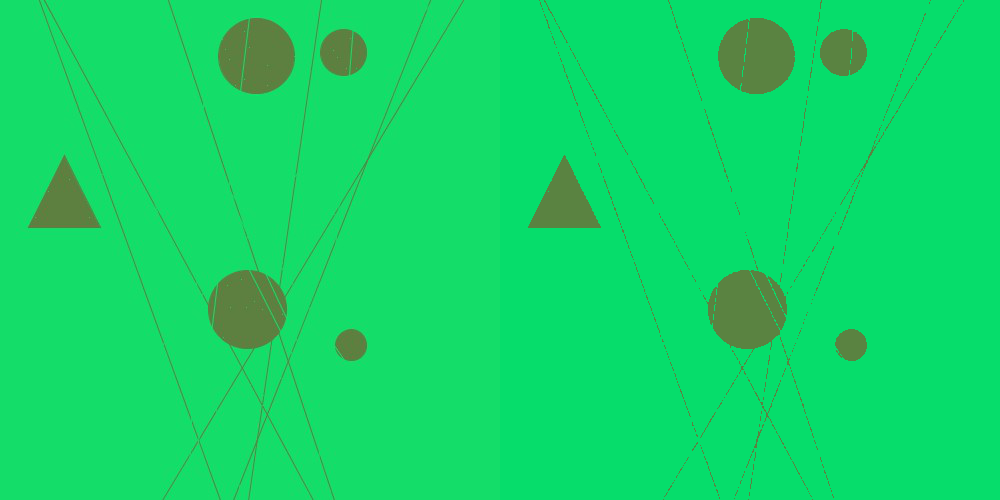

In [17]:
# display the images and wait for a keypress
out = np.hstack([image, red_img])
disp_image(out)

### Convert Background to black and shape to white

*Assumption is that the background is the color which takes up the majority of the pixel space.

Needs to handle posibility there is only one colour note two - encase of blank image

In [18]:
def convert_bw(image):
    '''
    input: image shape (500, 500, 3)
    output: B&W image shape (500,500,3)
    '''
    # input assertations
    assert(image.shape == (500, 500, 3))

    # number of unique pixels
    unique_pix = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    color_1 = unique_pix[0]
    
    # encase image is blank i.e. only bacground colour
    try:
        color_2 = unique_pix[1]
    except:
        color_2 = unique_pix[0]

    # Get indicies of two colors
    indices_1 = np.where(np.all(image == color_1, axis=-1))
    indices_2 = np.where(np.all(image == color_2, axis=-1))
    
    # number of pixels represented by each color
    pixels_color_1 = image[indices_1].shape[0]
    pixels_color_2 = image[indices_2].shape[0]

    # set background color to color represented by max pixels
    if pixels_color_1 > pixels_color_2:
        background_color = color_1
        shape_color = color_2
    else:
        background_color = color_2
        shape_color = color_1

    # Get indicies of background pixels
    indices_list = np.where(np.all(image == background_color, axis=-1))

    # Swap background color to black
    image[indices_list] = [0,0,0]

    # Get indicies of shape pixels
    indices_list = np.where(np.all(image == shape_color, axis=-1))

    # Swap background color to white
    image[indices_list] = [255,255,255]
    
    # output assertations
    assert(image.shape == (500, 500, 3))
    
    return image

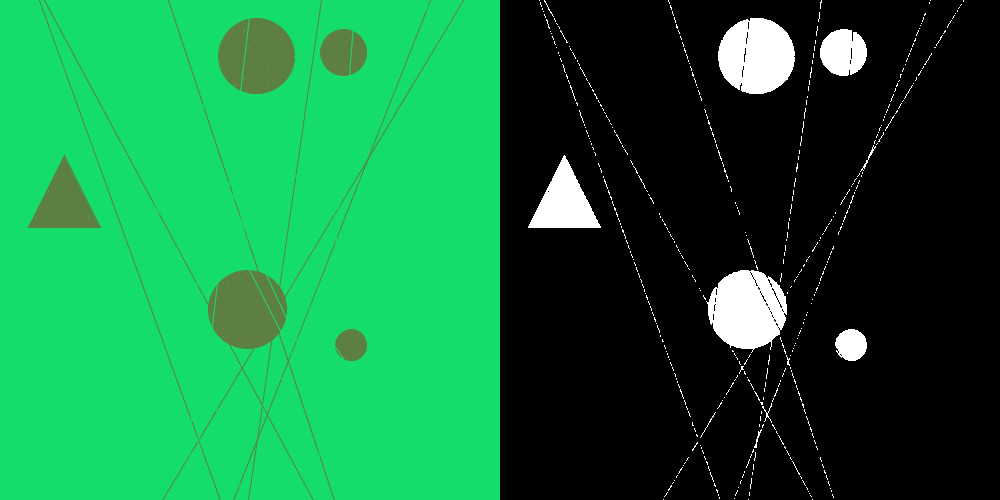

In [19]:
bw_img = convert_bw(red_img)

out = np.hstack([image, bw_img])
disp_image(out)

### Noise Reduction:

Understanding the parameters: http://www.ipol.im/pub/art/2011/bcm_nlm/

In [20]:
def deionize_img(image, blur=10):
    '''
    input: image shape (500, 500, 3)
    output: denoized image shape (500,500,3)
    '''
    # input assertations
    assert(image.shape == (500, 500, 3))
    
    image = cv2.fastNlMeansDenoisingColored(image,None,blur,10,7,21)
    
    # output assertations
    assert(image.shape == (500, 500, 3))
    return image

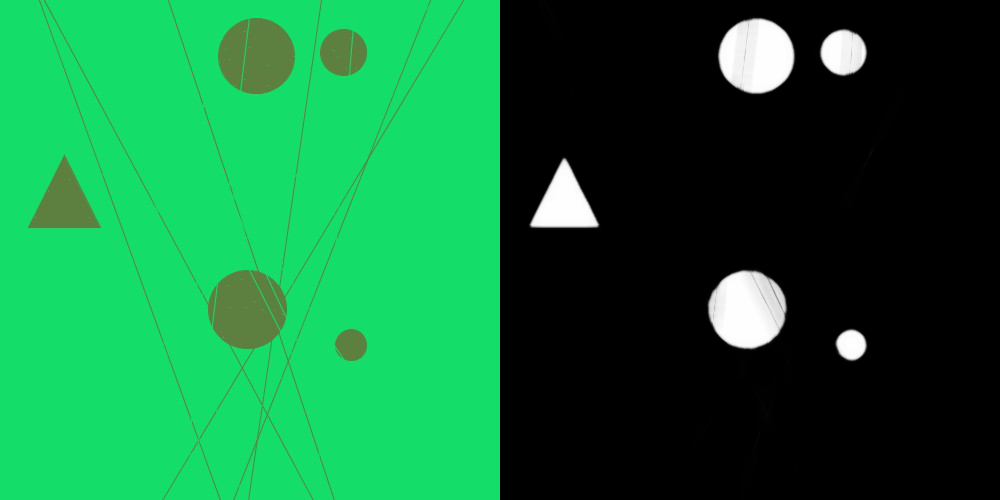

In [21]:
de_img = deionize_img(bw_img, blur=100)    

out = np.hstack([image, de_img])
disp_image(out)

### Image Sharpening:

After an interation of preprocessing without image sharpening, there was a clear trend where the missclassifications mostly fell into one of two areas:

* As expected - the shape detector is not correctly classifying overlapping images. 
* Difficulty classifying smaller images -- too much noise reduction potentially distorting image. Therefore there is a balance running the risk of identifying noise as a shape vs incorrectly identifying a shape due to denoising. 

<b>NOTE:</b> After experimenting with size reduction and sharpening, although they solved the problems set out in some circumstances, they invariable undid a lot of the good work the denoising function had done - this was very noticable. Also there is better performance with less preprocessing steps.

Other potential solutions:
* More sophisticated shape detector.

https://pythontic.com/image-processing/pillow/sharpen-filter

In [22]:
from PIL import Image
from PIL import ImageFilter

def sharpen(image):
    # convert np to PIL
    new_im = Image.fromarray(image)

    # Apply sharp filter
    sharpened1 = new_im.filter(ImageFilter.SHARPEN);
    sharpened2 = sharpened1.filter(ImageFilter.SHARPEN);
    sharpened3 = sharpened2.filter(ImageFilter.SHARPEN);
    sharpened4 = sharpened3.filter(ImageFilter.SHARPEN);
    
    im_np = np.asarray(sharpened4)
    
    return im_np

### Min Shape Size

After having added in resizing and image sharpening, we are getting fairly good results other than for some images with lots of line noise, detecting tiny pixel clusters as shapes.

Although not best practice, it seems reasonable/logical to put such a determanistic filter in. When line noise in the images is not reduced sufficiently the accuracy rate drops considerably as the shape detector detects many shapes in such images. Conversley if we may loose some accuracy with the smallest of 'real' shapes, however they are very few in number.

https://www.programcreek.com/python/example/86843/cv2.contourArea

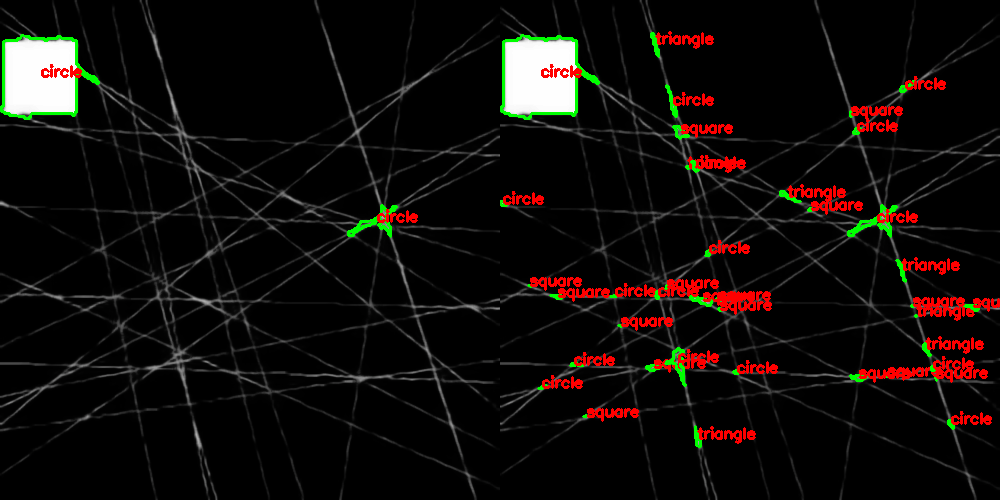

In [23]:
image_path = 'training_data/001250B001CD61-00149D3-0010889-001D52C-0014AD20015C380015AE3.jpg'
image = cv2.imread(image_path)
image = deionize_img(convert_bw(reduce_C_space(image)), blur=100)
image2 = image.copy()

img_with, y_pred = shape_detector(image, min_pixels=85, return_img=True)
img_without, y_pred = shape_detector(image2, min_pixels=0, return_img=True)

out = np.hstack([img_with, img_without])
disp_image(out)

### Seperate Shapes

Placeholder for future function. Will attempt to train image seperator in seperate workbook. 

In [24]:
def sep_shapes(image):
    return image

### Wrap Preprocessing into One Function

<b>NOTE:</b> After experimenting with sharpening, although they solved the problems set out in some circumstances, they invariable undid a lot of the good work the denoising function had done - this was very noticable. Also there is better performance with less preprocessing steps.

Decided to go with the following pre-processing steps:

* Reduce Colour Space using KMeans
* Convert to B&W
* Denoise

In [25]:
def preprocess(image, blur):

    image = deionize_img(convert_bw(reduce_C_space(image)), blur=blur)
    
    return image

### Preprocess Batch of Images and write images with Classification Errors to file and explore Trends

Throughout the process of experimenting with preprocessing steps I used this section as a simple visual check to see where the categorisation was going wrong. 

* As expected - the shape detector is not correctly classifying overlapping images. 
* Difficulty classifying smaller images -- too much noise reduction potentially distorting image. Therefore there is a balance running the risk of identifying noise as a shape vs incorrectly identifying a shape due to denoising. 

Potential solutions:
* More sophisticated shape detection algorithm
* Shape seperation algorithm


In [27]:
# init variables
X_processed = []
num_samples = X.shape[0]
return_img = False
timestart = timeit.default_timer()
y_hat = []

# iterate over unique contents - process over batch-size for speed
for img_i in range(X.shape[0]):

    if img_i<num_samples+1:
        # process and detect
        X_temp = unravel(X[img_i:img_i+1,])
        X_temp_pro = preprocess(X_temp, blur=100)
        X_processed.append(ravel(X_temp_pro))
        y_pred = shape_detector(X_temp_pro, min_pixels=85, return_img=return_img)
        
        # output image - for testing only
        if return_img:
            if not np.all(y_pred == y[img_i:img_i+1,]):
                out = np.hstack([X_temp, resize(img,width=500)])
                cv2.imwrite('processed1/'+img_paths[img_i:img_i+1][0][0]+'.jpg', out)
        
        # append prediction
        y_hat.append(y_pred)
        
        if img_i%250==0:
            timediff = timeit.default_timer() - timestart
            print('Read: ' + str(img_i) + ' images. Time: ' + str(timediff) + ' secs')

y_hat = np.array(y_hat)
X_processed = np.squeeze(X_processed, 1)

Read: 0 images. Time: 2.5653055149999915 secs
Read: 250 images. Time: 631.1993328230001 secs
Read: 500 images. Time: 1236.827227205 secs
Read: 750 images. Time: 1828.351011497 secs
Read: 1000 images. Time: 2406.793270241 secs
Read: 1250 images. Time: 3053.6478026180002 secs
Read: 1500 images. Time: 3669.700851193 secs
Read: 1750 images. Time: 4278.059196153 secs
Read: 2000 images. Time: 4887.8262802869995 secs
Read: 2250 images. Time: 5449.5014118789995 secs
Read: 2500 images. Time: 6020.620443291999 secs
Read: 2750 images. Time: 6658.975371441 secs
Read: 3000 images. Time: 7251.515355566 secs
Read: 3250 images. Time: 7817.202477999999 secs
Read: 3500 images. Time: 8373.554265248 secs
Read: 3750 images. Time: 8934.104225212 secs
Read: 4000 images. Time: 9493.156484505 secs
Read: 4250 images. Time: 10043.353602906 secs
Read: 4500 images. Time: 10602.768085996 secs
Read: 4750 images. Time: 11154.148922554 secs


### Accuracy

In [107]:
shape_acc, image_acc, diff = accuracy(y, y_hat_copy)
shape_acc, image_acc

(0.769, 0.8682, 0.6384) 0.7544


((0.769, 0.8682, 0.6384), 0.7544)

### Improvements
* Algorithm is struggling with small shapes as they become distorted - partiularly small triangles which I suspect is why over 5000 images the triangle accuracy (0.6384) is considerably lower. 
* Algorithm will not seperate overlapping shapes and sees them as one - train a more sophisticated shape detector on the processed dataset. 
* Possible more accurate shape detector could be achieved by training own supervised NN in Tensorflow. Consider convolutional neural netowrk with 4 Output Neurons representing num_shapes, num_circles, num_squares, num_triangles and an abs error as objective.
* As we are running K-Means clustering image by image, the solution takes around 2.5 seconds per image to run which is slow over a large dataset. Look for a quicker method - ideally something that can be put into a matrix operation. 